# Associate spindle/ripples and Ca2+ signal for multiple minian files
SHORT and focus on PFC

In [27]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import xarray as xr
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

In [28]:
folder = Path('Gaelle/Baseline_recording/ThreeColDots/')
session = 3
subsession = 4
numbsubsession = 5

folder_base = folder / f'session{session}/'
folder_Ephys = folder_base / f'OpenEphys/'
folder_Minis = folder_base / f'V4_Miniscope/session{session}{subsession}/minian/'

filenameE = folder_Ephys / f'SWRproperties.csv'
SWRprop = pd.read_csv(filenameE)
filenameE = folder_Ephys / f'Spindleproperties_PFC.csv'
PFCspiprop = pd.read_csv(filenameE)

filenameB = folder_base / f'SynchroFile.xlsx'
stamps = pd.read_excel(filenameB)

dict_minian = {}
for x in range(1, numbsubsession+1):
    folder_MinisSess = folder_base / f'V4_Miniscope/session{session}{x}/minian'
    dict_minian["ds_minian{0}".format(x)] = open_minian(folder_MinisSess)


for file_path in folder_base.glob('**/*timeStamps.csv'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'V4_Miniscope':
        stamps_miniscope = pd.read_csv(file_path)

Acq_freq = (list(stamps[0])[2])

TodropFile = folder_Minis / f'TodropFile.json'
with open(TodropFile, 'r') as f:
    unit_to_drop = json.load(f)

#TodropFile = folder_Minis / f'TokeepFile.json'
#with open(TodropFile, 'r') as f:
#    unit_to_keep = json.load(f)

TodropFile = folder_Minis / f'AllunitsFile.json'
with open(TodropFile, 'r') as f:
    All_units = json.load(f)

UnitToKeepL = [e for e in All_units if e not in unit_to_drop]
#UnitToKeepL = [e for e in All_units if e in unit_to_keep]
#unit_to_drop = [e for e in All_units if e not in unit_to_keep]
UnitToKeepInd = [e for e, elem in enumerate(All_units) if elem in UnitToKeepL]
print(UnitToKeepL)
print(unit_to_drop)
print(All_units)

[30, 34, 36, 39, 52, 66, 78, 86]
[0, 2, 3, 5, 6, 8, 10, 12, 15, 16, 17, 21, 24, 25, 26, 27, 28, 29, 32, 35, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 53, 55, 56, 58, 60, 63, 69, 71, 73, 74, 75, 76, 77, 82, 83, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 107, 109, 110, 112, 114, 117, 118, 121, 123, 125, 127, 129, 130, 131, 132, 133, 134, 135, 137, 141, 143, 144, 145, 147, 148, 150, 152, 153, 154, 155, 156, 157, 159, 160, 161, 165, 166, 170, 171, 172, 174, 175, 178, 179, 181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 195, 196]
[0, 2, 3, 5, 6, 8, 10, 12, 15, 16, 17, 21, 24, 25, 26, 27, 28, 29, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 58, 60, 63, 66, 69, 71, 73, 74, 75, 76, 77, 78, 82, 83, 86, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 107, 109, 110, 112, 114, 117, 118, 121, 123, 125, 127, 129, 130, 131, 132, 133, 134, 135, 137, 141, 143, 144, 145, 147, 148, 150, 152, 153, 154, 155, 156, 1

In [29]:

# start time
StartTime1 = (list(stamps[0])[0])

# start time session 2
def Convert(string):
    li = list(string.split(", "))
    li2 = len(li)
    return li2
stri = stamps[0][3]

numbdropfr = Convert(stri)


from ast import literal_eval
list_droppedframes = literal_eval(stamps[0][3])


dict_StartTime = {}
dict_StartTime[1] = (list(stamps[0])[0])
dict_EndTime = {}
dict_RecDur = {}
for x in range(1, numbsubsession+1):
    folder_MinisSess = folder_base / f'V4_Miniscope/session{session}{x}/minian'
    minian_ds = open_minian(folder_MinisSess)
    C = minian_ds['C']
    dict_RecDur[x] = C.shape[1]
    if len(list_droppedframes) > 0:
        numbdropfr = len(list(item for item in range(numbdropfr) if list_droppedframes[item] < dict_RecDur[x]))
    else:
        numbdropfr = 0
    dict_EndTime[x] = dict_StartTime[x] + (dict_RecDur[x] + numbdropfr)/stamps[0][2]
    if x < numbsubsession:
        dict_StartTime[x+1] = dict_EndTime[x]

print(dict_StartTime)
print(dict_EndTime)
print(dict_RecDur)

{1: 2.67248, 2: 836.0058133333333, 3: 1702.67248, 4: 2536.005813333333, 5: 3369.3391466666667}
{1: 836.0058133333333, 2: 1702.67248, 3: 2536.005813333333, 4: 3369.3391466666667, 5: 4407.339146666667}
{1: 25000, 2: 26000, 3: 25000, 4: 25000, 5: 31140}


In [30]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0
    if pos == len(myList):
        return len(myList)
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def take_closest2(myList, myNumber):
    value2 = 10000000
    for ind in range(len(myList)):
        value = abs(myList[ind]-myNumber)
        if value < value2:
            value2 = value
            index = myList[ind]
    return index


def take_closest3(myList, myNumber):
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        dummy = myList.index(after)
        return dummy
    else:
        dummy = myList.index(before)
        return dummy

In [31]:
StartTime = dict_StartTime[subsession]
EndTime = dict_EndTime[subsession]
rec_dur = dict_RecDur[subsession]
minian_ds = dict_minian[f"ds_minian{subsession}"]


PFCspiprop[["peak time", "start time", "end time"]] = PFCspiprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)
SWRprop[["peak time", "start time", "end time"]] = SWRprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)

C = minian_ds['C']
A = minian_ds['A']
B = A['unit_id']
A = minian_ds['A']
B = A['unit_id']
copyB = list(B.copy())
for i in range(len(unit_to_drop)):
    elem = unit_to_drop[i]
    copyB.remove(elem)
unit_to_keep = copyB

C = C.loc[unit_to_keep,:]
nb_unit = C.shape[0]
rec_dur = C.shape[1]

StartTimeIndexSpi = take_closest3(list(PFCspiprop["start time"]), StartTime*1000)
EndTimeIndex = take_closest3(list(PFCspiprop["start time"]), EndTime*1000)

if StartTimeIndexSpi > len(list(PFCspiprop["start time"])):
    StartTimeIndexSpi = 0
if EndTimeIndex > len(list(PFCspiprop["start time"])):
    EndTimeIndex = len(list(PFCspiprop["start time"]))

PFCspiprop = PFCspiprop[StartTimeIndexSpi:EndTimeIndex]

StartTimeIndex = take_closest3(list(SWRprop["start time"]), StartTime*1000)
EndTimeIndex = take_closest3(list(SWRprop["start time"]), EndTime*1000)
if StartTimeIndex > len(list(SWRprop["start time"])):
    StartTimeIndex = 0
if EndTimeIndex > len(list(SWRprop["start time"])):
    EndTimeIndex = len(list(SWRprop["start time"]))

SWRprop = SWRprop[StartTimeIndex:EndTimeIndex]

In [32]:
Struct = "PFC"
before = 1000 # ms
after = 1000 # ms
counterPrePFC = 0
counterPostPFC = 0
PreCoupled_spindlesPFC = list()
PostCoupled_spindlesPFC = list()
unCoupled_spindlesPFC = list()

nb_spindle = PFCspiprop.shape[0]
for Pspin in range(nb_spindle):
    ser = pd.Series(PFCspiprop["start time"])
    serSWR = list(pd.Series(SWRprop["start time"]))
    Combined_Spindle_SWR = take_closest2(serSWR, ser[Pspin + StartTimeIndexSpi])
    distance = Combined_Spindle_SWR - ser[Pspin + StartTimeIndexSpi]
    if (distance > (- before)) and (distance <  0):
        counterPrePFC = counterPrePFC + 1
        PreCoupled_spindlesPFC.append(Pspin)
    elif (distance > (0)) and (distance <  after):
        counterPostPFC = counterPostPFC + 1
        PostCoupled_spindlesPFC.append(Pspin)
    else:
        unCoupled_spindlesPFC.append(Pspin)

print(len(PreCoupled_spindlesPFC), len(PostCoupled_spindlesPFC), len(unCoupled_spindlesPFC))
#print(len(PreCoupled_spindlesPFC)/nb_spindle)
#print(len(PostCoupled_spindlesPFC)/nb_spindle)

10 5 8


post, unit =  0 spindle =  0
post, unit =  1 spindle =  0
post, unit =  2 spindle =  0
post, unit =  3 spindle =  0
post, unit =  4 spindle =  0
post, unit =  5 spindle =  0
post, unit =  6 spindle =  0
post, unit =  7 spindle =  0


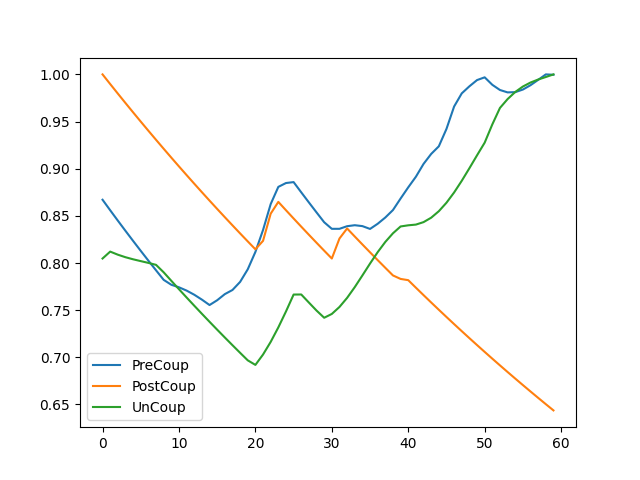

In [33]:
Cseries = C.to_series()
unit_to_keep = range(len(UnitToKeepInd))
duration = 1
Struct = "PFC"
threshold = 0.1

ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
time = range(duration*2*Acq_freq)
Half = int(ActivityCa_PFCspin.shape[0]/2)
TimeStamps_miniscope = list(stamps_miniscope["Time Stamp (ms)"] + (StartTime*1000))
plt.close()

AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
nAVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
for unit in unit_to_keep:
    ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
    for Pspin in PreCoupled_spindlesPFC:
        ser = list(pd.Series(PFCspiprop["start time"]))
        Frame_Spindle_start = take_closest2(TimeStamps_miniscope, ser[Pspin])
        index = TimeStamps_miniscope.index(Frame_Spindle_start)
        trace = list(lCseries[index-Half:index+Half])
        if len(trace)<len(time):
            print("pre, unit = ", unit, "spindle = ", Pspin)
        else:
            ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
    if max(ActivityCa_PFCspin)>(len(PreCoupled_spindlesPFC)*threshold):
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
    else:
        nActivityCa_PFCspin = 0#ActivityCa_PFCspin
    
    AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin    
    nAVGActivityCa_PFCspin = nAVGActivityCa_PFCspin + nActivityCa_PFCspin 

if max(AVGActivityCa_PFCspin)>(threshold):
    nAVGActivityCa_PFCspin = AVGActivityCa_PFCspin/max(AVGActivityCa_PFCspin)
else:
    nAVGActivityCa_PFCspin = AVGActivityCa_PFCspin

plt.plot(time, nAVGActivityCa_PFCspin, label='PreCoup')  

prCactBefore = sum(AVGActivityCa_PFCspin[0:Half])
prCactAfter = sum(AVGActivityCa_PFCspin[Half:2*Half])
nprCactBefore = sum(nAVGActivityCa_PFCspin[0:Half])
nprCactAfter = sum(nAVGActivityCa_PFCspin[Half:2*Half])


AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
nAVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
for unit in unit_to_keep:
    ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
    for Pspin in PostCoupled_spindlesPFC:
        ser = list(pd.Series(PFCspiprop["start time"]))
        Frame_Spindle_start = take_closest2(TimeStamps_miniscope, ser[Pspin])
        index = TimeStamps_miniscope.index(Frame_Spindle_start)
        trace = list(lCseries[index-Half:index+Half])
        if len(trace)<len(time):
            print("post, unit = ", unit, "spindle = ", Pspin)
        else:
            ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
    if max(ActivityCa_PFCspin)>(len(PostCoupled_spindlesPFC)*threshold):
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
    else:
        nActivityCa_PFCspin = 0#ActivityCa_PFCspin
    AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin    
    nAVGActivityCa_PFCspin = nAVGActivityCa_PFCspin + nActivityCa_PFCspin 

if max(AVGActivityCa_PFCspin)>(threshold):
    nAVGActivityCa_PFCspin = AVGActivityCa_PFCspin/max(AVGActivityCa_PFCspin)
else:
    nAVGActivityCa_PFCspin = AVGActivityCa_PFCspin

plt.plot(time, nAVGActivityCa_PFCspin, label='PostCoup')  
poCactBefore = sum(AVGActivityCa_PFCspin[0:Half])
poCactAfter = sum(AVGActivityCa_PFCspin[Half:2*Half])
npoCactBefore = sum(nAVGActivityCa_PFCspin[0:Half])
npoCactAfter = sum(nAVGActivityCa_PFCspin[Half:2*Half])

AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
nAVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
for unit in unit_to_keep:
    ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
    for Pspin in unCoupled_spindlesPFC:
        ser = list(pd.Series(PFCspiprop["start time"]))
        Frame_Spindle_start = take_closest2(TimeStamps_miniscope, ser[Pspin])
        index = TimeStamps_miniscope.index(Frame_Spindle_start)
        trace = list(lCseries[index-Half:index+Half])
        if len(trace)<len(time):
            print("post, unit = ", unit, "spindle = ", Pspin)
        else:
            ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
    if max(ActivityCa_PFCspin)>(len(unCoupled_spindlesPFC)*threshold):
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
    else:
        nActivityCa_PFCspin = 0#ActivityCa_PFCspin
    AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin    
    nAVGActivityCa_PFCspin = nAVGActivityCa_PFCspin + nActivityCa_PFCspin 

if max(AVGActivityCa_PFCspin)>(threshold):
    nAVGActivityCa_PFCspin = AVGActivityCa_PFCspin/max(AVGActivityCa_PFCspin)
else:
    nAVGActivityCa_PFCspin = AVGActivityCa_PFCspin

plt.plot(time, nAVGActivityCa_PFCspin, label='UnCoup')
unCactBefore = sum(AVGActivityCa_PFCspin[0:Half])
unCactAfter = sum(AVGActivityCa_PFCspin[Half:2*Half])
nunCactBefore = sum(nAVGActivityCa_PFCspin[0:Half])
nunCactAfter = sum(nAVGActivityCa_PFCspin[Half:2*Half])

plt.legend();
plt.show()

In [34]:
negCoupledBef = prCactBefore
negCoupledAft = prCactAfter
nnegCoupledBef = nprCactBefore
nnegCoupledAft = nprCactAfter

posCoupledBef = poCactBefore
posCoupledAft = poCactAfter
nposCoupledBef = npoCactBefore
nposCoupledAft = npoCactAfter

unCoupledBef = unCactBefore
unCoupledAft = unCactAfter
nunCoupledBef = nunCactBefore
nunCoupledAft = nunCactAfter

outSumm = pd.Series([negCoupledBef, negCoupledAft, posCoupledBef, posCoupledAft, unCoupledBef, unCoupledAft, nnegCoupledBef, nnegCoupledAft, nposCoupledBef, nposCoupledAft, nunCoupledBef, nunCoupledAft],
              index=["NCB", "NCA", "PCB", "PCA", "1CB", "1CA", "nNCB", "nNCA", "nPCB", "nPCA", "n1CB", "n1CA"])

filenameOut = folder_base / f'Ca2+intSWRspindles.xlsx'
writer = pd.ExcelWriter(filenameOut)
outSumm.to_excel(writer)
writer.save()
filenameOut = folder_Minis / f'Ca2+intSWRspindles.xlsx'
writer = pd.ExcelWriter(filenameOut)
outSumm.to_excel(writer)

writer.save()
outSumm

NCB     435.354662
NCA     492.880007
PCB     152.521163
PCA     128.215788
1CB     364.790151
1CA     423.217273
nNCB     24.488678
nNCA     27.724476
nPCB     26.534822
nPCA     22.306302
n1CB     22.720135
n1CA     26.359138
dtype: float64